Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Installing  libraries

In [2]:
!pip install Augmentor
!pip install keras_tuner

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
import Augmentor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.regularizers import l2


import keras_tuner

from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from tensorflow.keras import losses


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# mounting the google drive
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#Path to local directory as GPU limit has run out in Colab
path_to_images_dataset='D:\\iiitb\\CNN\\melanoma\\'
path_to_training_dataset=path_to_images_dataset+'\\Train\\'
path_to_test_dataset=path_to_images_dataset+'\\Test\\'

data_dir_train = pathlib.Path(path_to_training_dataset)
data_dir_test = pathlib.Path(path_to_test_dataset)

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [4]:
#Path of Train datset
path_list = list(data_dir_train.glob('*/*.jpg'))
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
set(lesion_list)

{'actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion'}

In [5]:
#Store all images info in a dataframe
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df.head(2)

Path              Label
0  D:\iiitb\CNN\melanoma\Train\actinic keratosis\...  actinic keratosis
1  D:\iiitb\CNN\melanoma\Train\actinic keratosis\...  actinic keratosis

In [6]:
# Get the number of images per class to check if the class are balanced
count_df=original_df.groupby('Label').count()
count_df=count_df.reset_index()
count_df

Label  Path
0           actinic keratosis   114
1        basal cell carcinoma   376
2              dermatofibroma    95
3                    melanoma   438
4                       nevus   357
5  pigmented benign keratosis   462
6        seborrheic keratosis    77
7     squamous cell carcinoma   181
8             vascular lesion   139

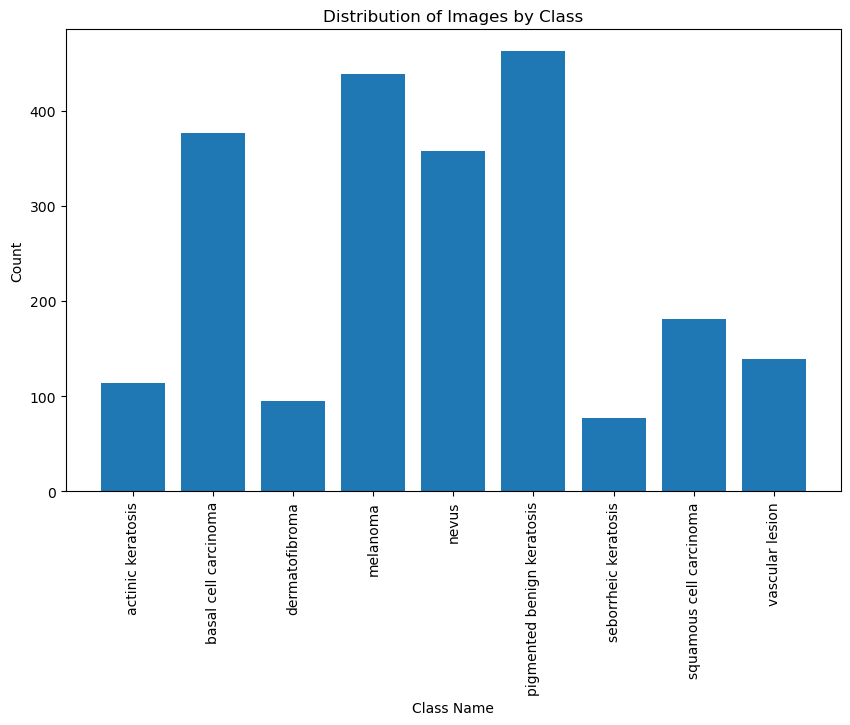

In [45]:
#Plot the count of images by class, the data is imbalanced between classes.
#pigmented benign keratosis has more images and seborrheic keratosis has less images
plt.figure(figsize=(10, 6))
plt.bar(count_df.Label, count_df.Path)
plt.xticks(rotation=90)
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.title('Distribution of Images by Class')
plt.show()

#### Finding - Pigmented Benign Keratosis class has higher number of samples whereas Seborrheic Keratosis has least number of samples.

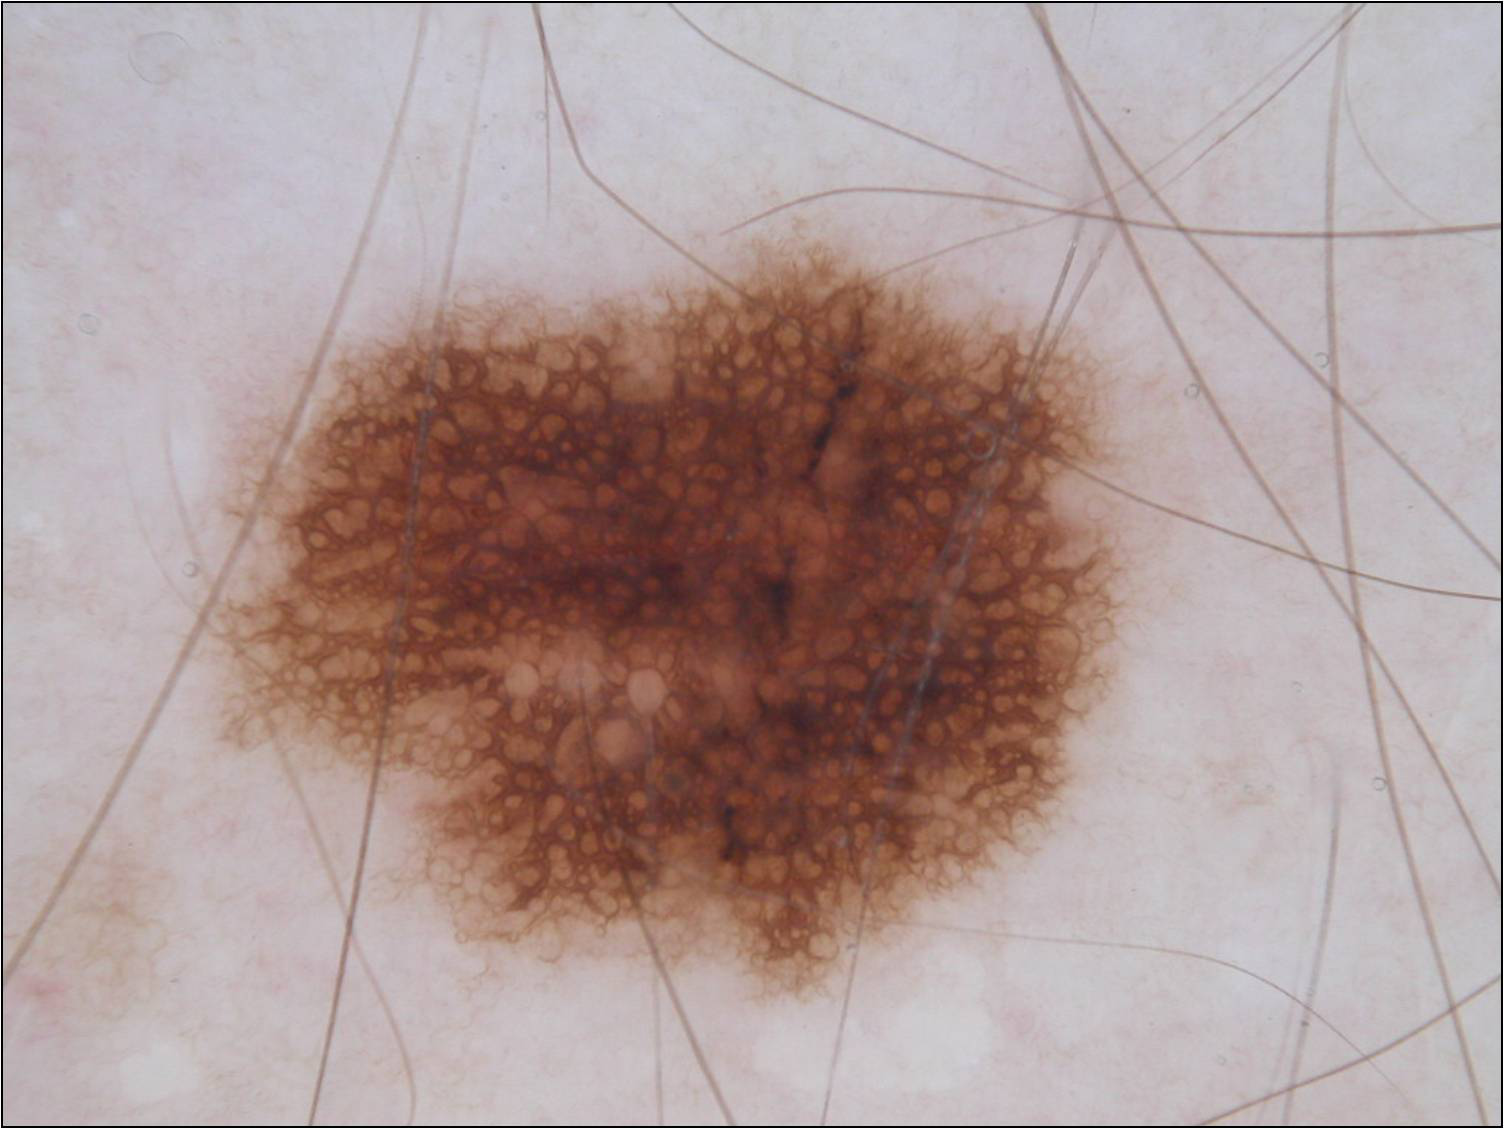

In [46]:
#Load the first image of nevus
nevus = list(data_dir_train.glob('nevus/*'))
PIL.Image.open(str(nevus[0]))

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create train and test datasets




In [7]:
#Define parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180
num_classes=9


Use 80% of the images for training, and 20% for validation.

In [8]:
#Create train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
                  directory=data_dir_train,
                  labels= 'inferred',
                  color_mode='rgb',
                  batch_size=batch_size,
                  seed=123,
                  shuffle=True,
                  validation_split=0.2,
                  subset="training",
                  image_size=(180, 180) )

Found 5239 files belonging to 9 classes.
Using 4192 files for training.


In [9]:
## Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
                  directory=data_dir_train,
                  labels= 'inferred',
                  color_mode='rgb',
                  batch_size=batch_size,
                  seed=123,
                  shuffle=True,
                  validation_split=0.2,
                  subset="validation",
                  image_size=(180, 180) )


Found 5239 files belonging to 9 classes.
Using 1047 files for validation.


In [10]:
## Create test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
                  directory=data_dir_test,
                  labels= 'inferred',
                  color_mode='rgb',
                  batch_size=batch_size,
                  seed=123,
                  image_size=(180, 180) )



Found 118 files belonging to 9 classes.


In [11]:
#Checking the size of training image
for images, labels in train_ds.take(1):
  print(images.shape)
  print(labels.shape)

(32, 180, 180, 3)
(32,)


In [12]:
for images, labels in val_ds.take(1):
  print(images.shape)
  print(labels.shape)

(32, 180, 180, 3)
(32,)


In [13]:
# List out all the classes of skin cancer and store them in a list. there are 9 classes.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### Visualize one image from each class


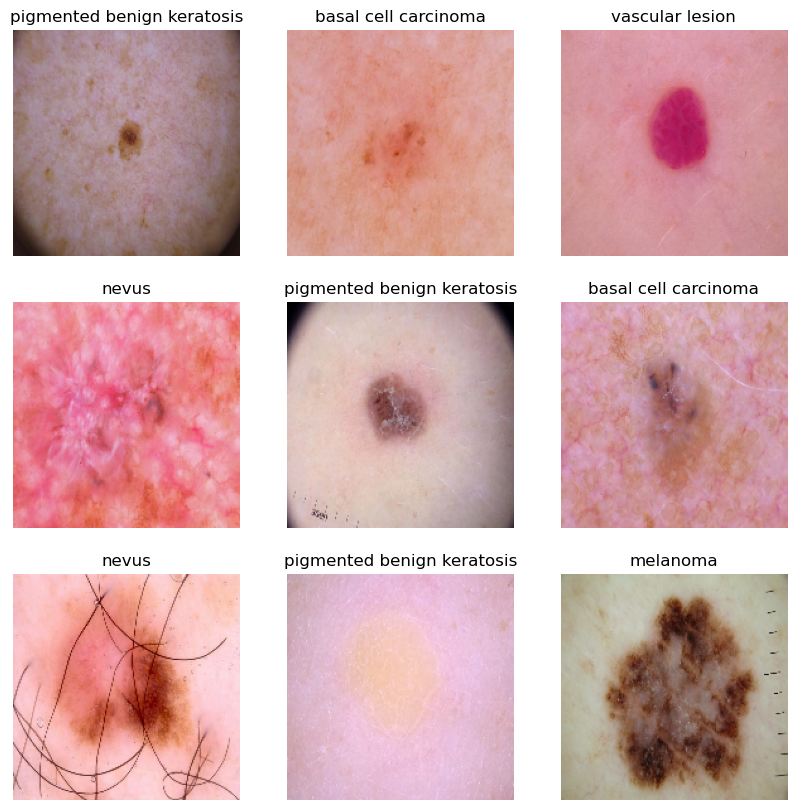

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [81]:

# Create a basic CNN model by rescaling
basic_model = Sequential([
  layers.Input(shape= (img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


In [24]:
#Reusable code for model compilation, summary and training the model
def model_compile_fit(model, epochs, optimizer, metrics='accuracy', loss='sparse_categorical_crossentropy', train_ds=train_ds, val_ds=val_ds):
    
    epochs=epochs
    model.compile(optimizer=optimizer,  loss=loss,   metrics=[metrics])
    
    
    print("Model Summary")
    model.summary()
    
    print("Starting epochs")
    # early_stopping to prevent overfitting
    early_stopping = [EarlyStopping(monitor='val_loss', patience=5),
                      ModelCheckpoint(filepath=path_to_images_dataset+'\\best_model.keras',
                                      monitor='val_accuracy', save_best_only=True)
                      ]

    
    print("Training the Model")
    history = model.fit( train_ds, validation_data=val_ds, epochs=epochs,shuffle=True,batch_size=batch_size , callbacks = early_stopping)
    return history

In [210]:
#Compile and train the model
basic_history=model_compile_fit(basic_model, epochs=30, optimizer='adam')

Model Summary


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Starting epochs
Training the Model
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.5736 - loss: 1.3196 - val_accuracy: 0.5168 - val_loss: 1.4990
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.6730 - loss: 0.9385 - val_accuracy: 0.5168 - val_loss: 1.5148
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.6978 - loss: 0.8444 - val_accuracy: 0.5324 - val_loss: 1.7385
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.7078 - loss: 0.8020 - val_accuracy: 0.4832 - val_loss: 1.8955
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.7177 - loss: 0.7950 - val_accuracy: 0.5190 - val_loss: 1.8160
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.7293 - loss: 0.7108 - val_accuracy: 0.5145 - val_loss: 1.8648


In [25]:
#Reusable code for plotting model accuracy
def model_accuracy(history):
    # list all data in history
    print(history.history.keys())
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


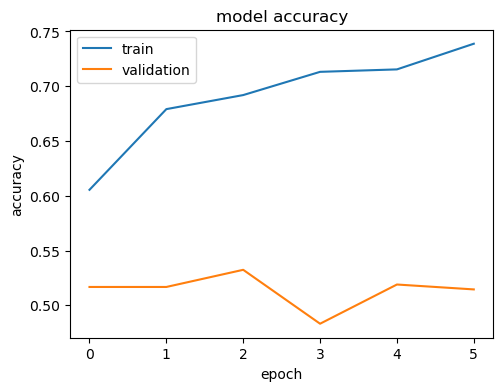

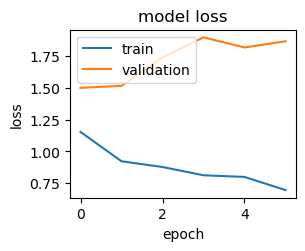

In [213]:
# Visualize the train and validation accuracy
model_accuracy(basic_history)

In [214]:
# Model evaluation on test dataset, 
basic_model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2827 - loss: 4.2164


[4.113035678863525, 0.27966102957725525]

#### Finding: The model has overfitted on the data, hence it has stopped early, the training accuracy is high, but both validation and test accuracy is very low

In [215]:
#Introducing dropout to reduce overfitting
basic_dropout_model = Sequential([
  layers.Input(shape= (img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])


In [216]:
# Compile and train the model
basic_dropout_history=model_compile_fit(basic_dropout_model, epochs=30, optimizer='adam')

Model Summary


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_26 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_84 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_83 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_84 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_85 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Starting epochs
Training the Model
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.1961 - loss: 2.3692 - val_accuracy: 0.3781 - val_loss: 1.8393
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.3604 - loss: 1.7630 - val_accuracy: 0.4743 - val_loss: 1.5938
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.4415 - loss: 1.5465 - val_accuracy: 0.4631 - val_loss: 1.5061
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.4923 - loss: 1.4753 - val_accuracy: 0.4944 - val_loss: 1.4172
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.5078 - loss: 1.3861 - val_accuracy: 0.5280 - val_loss: 1.3690
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.5290 - loss: 1.3498 - val_accuracy: 0.5414 - val_loss: 1.3777
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.5491 - loss: 1.2456 - val_accuracy: 0.5526 - val_loss: 1.3478
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy:

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


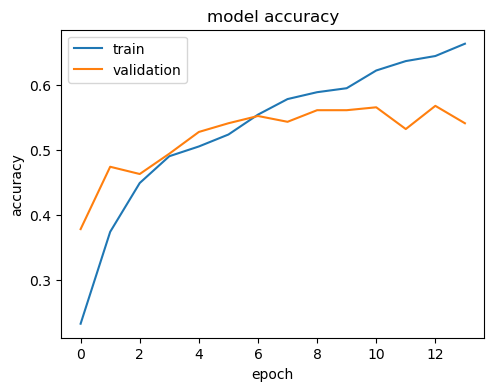

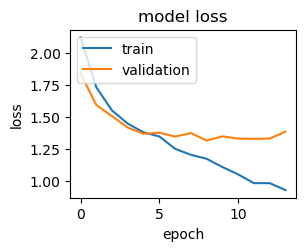

In [217]:
# Visualize the accuracy of train and validation data
model_accuracy(basic_dropout_history)

In [218]:
# Model evaluation on test dataset on basic_dropout_model
basic_dropout_model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3557 - loss: 3.4414


[3.4885051250457764, 0.3813559412956238]

#### Finding: Model has overfitted inspite of introducing dropouts

In [131]:
# Compile and train the model using sgd optimizer
sgd_dropout_basic_history=model_compile_fit(basic_dropout_model, epochs=30, optimizer='sgd')

Model Summary


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Starting epochs
Training the Model
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.2277 - loss: 52.7900 - val_accuracy: 0.1499 - val_loss: 2.1576
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.1779 - loss: 2.1227 - val_accuracy: 0.1499 - val_loss: 2.0859
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.1626 - loss: 2.0904 - val_accuracy: 0.1521 - val_loss: 2.0421
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.1997 - loss: 2.0428 - val_accuracy: 0.1946 - val_loss: 2.0345
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.2067 - loss: 2.0446 - val_accuracy: 0.2058 - val_loss: 2.0244
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.1926 - loss: 2.0354 - val_accuracy: 0.1924 - val_loss: 2.0251
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.1793 - loss: 2.0527 - val_accuracy: 0.1991 - val_loss: 2.0237
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.20

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


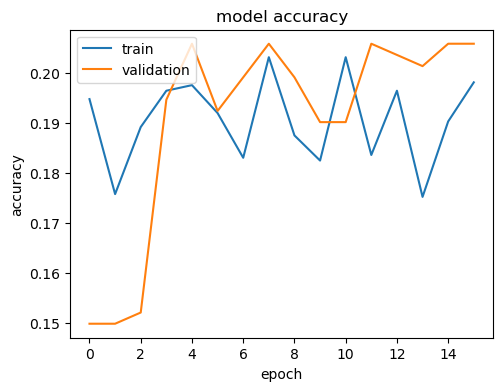

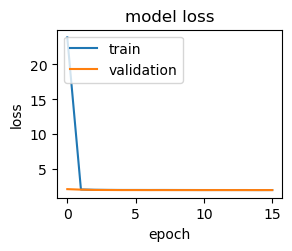

In [132]:
# Visualize the accuracy of train and validation data, adam optimizer is performing better over sgd.
model_accuracy(sgd_dropout_basic_history)

In [134]:
# Model evaluation on test dataset using sgd, Adam optimizer seems to be performing better
basic_dropout_model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1334 - loss: 2.2100


[2.228285789489746, 0.1355932205915451]

#### Finding: With SGD, the model training, validation and test accuracies are significantly lesser. So will continue to use Adam optimizer

### Data Augmentation

In [48]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomRotation(factor=0.4, fill_mode="wrap"),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
    layers.RandomContrast(factor=0.2)
  ]
)

In [222]:
#Model with data augmentation
data_augment_model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

In [223]:
data_augment_history=model_compile_fit(data_augment_model, epochs=30, optimizer='adam')

Model Summary


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_29 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_28 (Rescaling)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_90 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_89 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_91 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_90 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_91 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Starting epochs
Training the Model
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.1580 - loss: 2.4754 - val_accuracy: 0.2260 - val_loss: 2.0182
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.2333 - loss: 2.0028 - val_accuracy: 0.2685 - val_loss: 1.9405
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 323ms/step - accuracy: 0.2854 - loss: 1.9301 - val_accuracy: 0.2908 - val_loss: 1.8328
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.3218 - loss: 1.8419 - val_accuracy: 0.4541 - val_loss: 1.6174
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - accuracy: 0.3795 - loss: 1.6837 - val_accuracy: 0.4720 - val_loss: 1.5421
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 331ms/step - accuracy: 0.3995 - loss: 1.6733 - val_accuracy: 0.4541 - val_loss: 1.5642
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.4408 - loss: 1.5985 - val_accuracy: 0.4989 - val_loss: 1.5236
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accurac

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


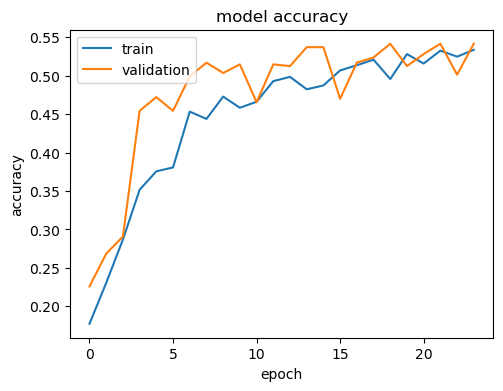

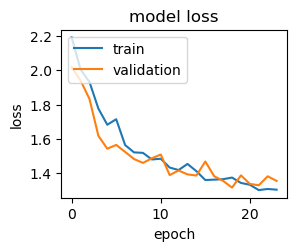

In [224]:
# With data augmentation both the training and validation accuracy seems to be increasing in proportion
model_accuracy(data_augment_history)

In [226]:
# Model evaluation on test dataset, 
data_augment_model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3767 - loss: 2.2633


[2.313072443008423, 0.35593220591545105]

#### Finding: With data augmentation both the training and validation accuracy seems to be increasing in proportion, even there is an increase in test accuracy

#### Rectify the class imbalance


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
data_dir_train_modified = pathlib.Path(path_to_training_dataset)
print(data_dir_train_modified)
print(class_names)

class_names_medium_images = ['actinic keratosis',   'squamous cell carcinoma', 'vascular lesion']
class_names_less_images =['dermatofibroma',  'seborrheic keratosis']


D:\iiitb\CNN\melanoma\Train
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [27]:
for class_name in class_names:
   p = Augmentor.Pipeline(path_to_training_dataset + class_name)

   p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
   p.zoom(probability=0.5, min_factor=1.1, max_factor=1.6)
   p.sample(500)

Initialised with 114 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C83DCF8350>: 100%|█| 300/300 [00:02<00:00, 123.32 Samples


Initialised with 376 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C83DCE3090>: 100%|█| 300/300 [00:02<00:00, 119.89 Samples


Initialised with 95 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2C82AA4D250>: 100%|█| 300/300 [00:02<00:


Initialised with 438 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x2C82A7A9890>: 100%|█| 300/300 [00:31<00:00,  9.54 Sample


Initialised with 357 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x2C82A8D39D0>: 100%|█| 300/300 [00:27<00:00, 10.99 Sample


Initialised with 462 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2C82A8E1750>: 100%|█| 300/300 [00:05<00:


Initialised with 77 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2C83DDB1C90>: 100%|█| 300/300 [00:13<00


Initialised with 181 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C83DCDCF50>: 100%|█| 300/300 [00:05<00:00, 50.17 Samples/


Initialised with 139 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C83DD18590>: 100%|█| 300/300 [00:06<00:00, 49.55 Samples/


In [28]:
for class_name in class_names_medium_images:
   p = Augmentor.Pipeline(path_to_training_dataset + class_name)

   p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
   p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
   p.sample(500)

Initialised with 114 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C83512FE50>: 100%|█| 300/300 [00:05<00:00, 53.12 Samples/


Initialised with 181 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C83DD49D90>: 100%|█| 300/300 [00:05<00:00, 53.24 Samples/


Initialised with 139 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C83DCD7050>: 100%|█| 300/300 [00:05<00:00, 54.67 Samples/


In [29]:
for class_name in class_names_less_images:
   p = Augmentor.Pipeline(path_to_training_dataset + class_name)

   p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
   p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
   p.sample(550)

Initialised with 95 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C83DD1D290>: 100%|█| 300/300 [00:05<00:00, 54.39 Samples/


Initialised with 77 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2C83DDEC610>: 100%|█| 300/300 [00:12<00:00, 23.08 Samples


In [37]:
p = Augmentor.Pipeline(path_to_training_dataset + 'melanoma')

p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.sample(300)

Initialised with 438 image(s) found.
Output directory set to D:\iiitb\CNN\melanoma\\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2C83DC31410>: 100%|█| 200/200 [00:09<00:00, 21.95 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

7400


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [32]:
#Rename the files to replace '.jpg_'
for filename in path_list:
    print(filename.replace('.jpg_','') )
    os.rename(filename, filename.replace('.jpg_','') )
    

D:\iiitb\CNN\melanoma\Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025780755cc973-a927-4a00-895b-5f1d9e561ad4.jpg
D:\iiitb\CNN\melanoma\Train\actinic keratosis\output\actinic keratosis_original_ISIC_002578095f5b6bd-108a-4fa5-800f-bd8aa81548f1.jpg
D:\iiitb\CNN\melanoma\Train\actinic keratosis\output\actinic keratosis_original_ISIC_00257809df4d6a7-1204-479d-98c5-2963b7b96a37.jpg
D:\iiitb\CNN\melanoma\Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025780a7175406-c822-4073-a597-d5af60913cba.jpg
D:\iiitb\CNN\melanoma\Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025780cf34d53e-dcb8-4ac0-badf-118a07655299.jpg
D:\iiitb\CNN\melanoma\Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025780e9780343-6605-4fa8-93d5-4e1c0660ac1d.jpg
D:\iiitb\CNN\melanoma\Train\actinic keratosis\output\actinic keratosis_original_ISIC_002578052ffc424-9bae-4741-a1f2-fcacb2b96124.jpg
D:\iiitb\CNN\melanoma\Train\actinic keratosis\output\actinic keratosi

In [40]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
set(lesion_list_new)

{'actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion'}

In [41]:
#create a dataframe with augmented image details
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
#Merge actual and augmented images
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

C:\Users\Lakshmi Y\AppData\Local\Temp\ipykernel_20236\1868377442.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [43]:
# Check the image count with augmented images, seems to be fairly balanced
new_df['Label'].value_counts()

melanoma                      1238
squamous cell carcinoma       1181
dermatofibroma                1145
vascular lesion               1139
seborrheic keratosis          1127
actinic keratosis             1114
pigmented benign keratosis     962
basal cell carcinoma           876
nevus                          857
Name: Label, dtype: int64

#### Train the model on the data created using Augmentor

In [44]:
#Create train dataset
augmented_train_ds = tf.keras.utils.image_dataset_from_directory(
                  directory=data_dir_train,
                  labels= 'inferred',
                  color_mode='rgb',
                  batch_size=batch_size,
                  seed=123,
                  shuffle=True,
                  validation_split=0.2,
                  subset="training",
                  image_size=(180, 180) )

Found 9639 files belonging to 9 classes.
Using 7712 files for training.


In [45]:
## Validation dataset
augmented_val_ds = tf.keras.utils.image_dataset_from_directory(
                  directory=data_dir_train,
                  labels= 'inferred',
                   color_mode='rgb',
                  batch_size=batch_size,
                  seed=123,
                  shuffle=True,
                  validation_split=0.2,
                  subset="validation",
                  image_size=(180, 180) )

Found 9639 files belonging to 9 classes.
Using 1927 files for validation.


#### Create, train, visualize and evaluate the model with more balanced number of images by class

In [46]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

augmented_train_ds = augmented_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
augmented_val_ds = augmented_val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [49]:
#Model with data augmentation
rebalance_data_augment_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

In [50]:
rebalance_data_augment_history=model_compile_fit(rebalance_data_augment_model, epochs=30, optimizer='adam', train_ds=augmented_train_ds, val_ds=augmented_val_ds)

Model Summary


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Starting epochs
Training the Model
Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 88s 335ms/step - accuracy: 0.2110 - loss: 2.0197 - val_accuracy: 0.3638 - val_loss: 1.5754
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 80s 334ms/step - accuracy: 0.3535 - loss: 1.6298 - val_accuracy: 0.4292 - val_loss: 1.4455
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 81s 335ms/step - accuracy: 0.3933 - loss: 1.5405 - val_accuracy: 0.4494 - val_loss: 1.3664
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 80s 331ms/step - accuracy: 0.4135 - loss: 1.4730 - val_accuracy: 0.4427 - val_loss: 1.3872
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 80s 330ms/step - accuracy: 0.4271 - loss: 1.4440 - val_accuracy: 0.4878 - val_loss: 1.3039
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 326ms/step - accuracy: 0.4318 - loss: 1.4194 - val_accuracy: 0.4847 - val_loss: 1.2852
Epoch 7/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 62s 258ms/step - accuracy: 0.4404 - loss: 1.3982 - val_accuracy: 0.4868 - val_loss: 1.2568
Epoch 8/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 49s 201m

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


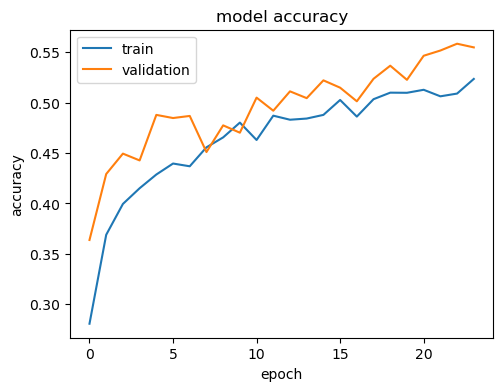

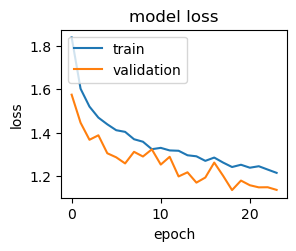

In [51]:
#Visualize the accuracy of train and validation dataset, both train and validation accuracies have improved with rebalance of datasets
model_accuracy(rebalance_data_augment_history)

#### Finding:  Both train and validation accuracies have improved with rebalance of datasets

In [52]:
# Model evaluation on test dataset, 
rebalance_data_augment_model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.4020 - loss: 2.1879


[2.308541774749756, 0.43220338225364685]

#### Finding: Rebalancing the classes increased the test accuracy by 3-4%. It is still not able to predict unseen patterns well. Validation accuracy is higher than training accuracy

#### Adding one more convolution layer

In [53]:
#Model with data augmentation
rebalance_conv_data_augment_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

In [54]:
rebalance_conv_data_augment_history=model_compile_fit(rebalance_conv_data_augment_model, epochs=40, optimizer='adam', train_ds=augmented_train_ds, val_ds=augmented_val_ds)

Model Summary


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,965,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,064,937 (15.51 MB)

 Trainable params: 4,064,937 (15.51 MB)

 Non-trainable params: 0 (0.00 B)

Starting epochs
Training the Model
Epoch 1/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 86s 347ms/step - accuracy: 0.1857 - loss: 2.1383 - val_accuracy: 0.3300 - val_loss: 1.7019
Epoch 2/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 80s 332ms/step - accuracy: 0.3598 - loss: 1.6203 - val_accuracy: 0.3799 - val_loss: 1.5919
Epoch 3/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 59s 244ms/step - accuracy: 0.4021 - loss: 1.5410 - val_accuracy: 0.4318 - val_loss: 1.4317
Epoch 4/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 56s 231ms/step - accuracy: 0.4092 - loss: 1.5006 - val_accuracy: 0.4229 - val_loss: 1.4647
Epoch 5/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 56s 234ms/step - accuracy: 0.4391 - loss: 1.3951 - val_accuracy: 0.4774 - val_loss: 1.3351
Epoch 6/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 56s 232ms/step - accuracy: 0.4542 - loss: 1.3853 - val_accuracy: 0.4312 - val_loss: 1.4347
Epoch 7/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 58s 239ms/step - accuracy: 0.4542 - loss: 1.3604 - val_accuracy: 0.4826 - val_loss: 1.3085
Epoch 8/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 59s 244m

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


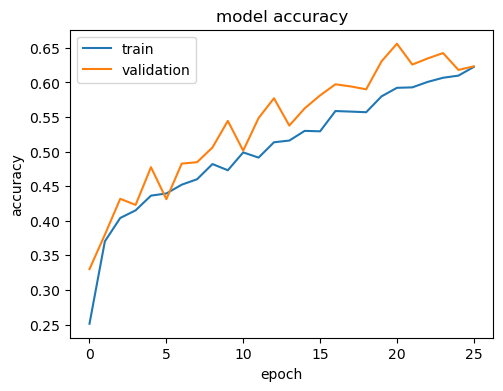

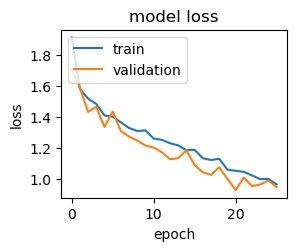

In [57]:
model_accuracy(rebalance_conv_data_augment_history)

In [58]:
# Model evaluation on test dataset, 
rebalance_conv_data_augment_model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4169 - loss: 2.2275


[2.2552430629730225, 0.4067796468734741]

#### Finding: Adding one more convolution layer has improved the train, validation and test accuracy looks like it has learnt more features

In [61]:
# Increasing the feature maps
rebalance_feature_map_data_augment_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
       layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
      layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

In [62]:
rebalance_feature_map_data_augment_history=model_compile_fit(rebalance_feature_map_data_augment_model, epochs=30, optimizer='adam', train_ds=augmented_train_ds, val_ds=augmented_val_ds)

Model Summary


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       7,930,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,320,841 (31.74 MB)

 Trainable params: 8,320,841 (31.74 MB)

 Non-trainable params: 0 (0.00 B)

Starting epochs
Training the Model
Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 201s 829ms/step - accuracy: 0.1555 - loss: 3.0135 - val_accuracy: 0.3212 - val_loss: 1.7379
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 207s 858ms/step - accuracy: 0.3029 - loss: 1.8252 - val_accuracy: 0.3394 - val_loss: 1.7275
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 205s 852ms/step - accuracy: 0.3285 - loss: 1.7962 - val_accuracy: 0.3991 - val_loss: 1.5710
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 204s 846ms/step - accuracy: 0.3412 - loss: 1.6984 - val_accuracy: 0.3934 - val_loss: 1.5832
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 204s 847ms/step - accuracy: 0.3651 - loss: 1.6680 - val_accuracy: 0.3643 - val_loss: 1.6572
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 207s 858ms/step - accuracy: 0.3745 - loss: 1.6468 - val_accuracy: 0.4027 - val_loss: 1.5399
Epoch 7/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 205s 849ms/step - accuracy: 0.3690 - loss: 1.6984 - val_accuracy: 0.4349 - val_loss: 1.5379
Epoch 8/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 2

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


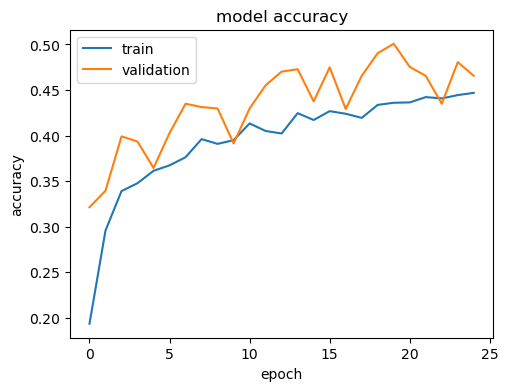

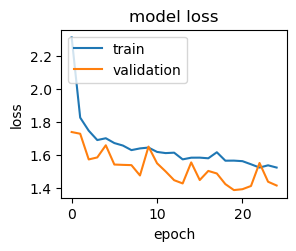

In [63]:
model_accuracy(rebalance_feature_map_data_augment_history)

In [64]:
rebalance_feature_map_data_augment_model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4218 - loss: 2.0199


[2.067497730255127, 0.39830508828163147]

#### Finding:It doesn't seem to overfit, now train, validation and test accuracy is almost same. Increasing the feature maps didn't contribute to the test accuracy.